<h1> Practical Attack Case Study: Image Classification of Checks in Financial Institutions </h1>

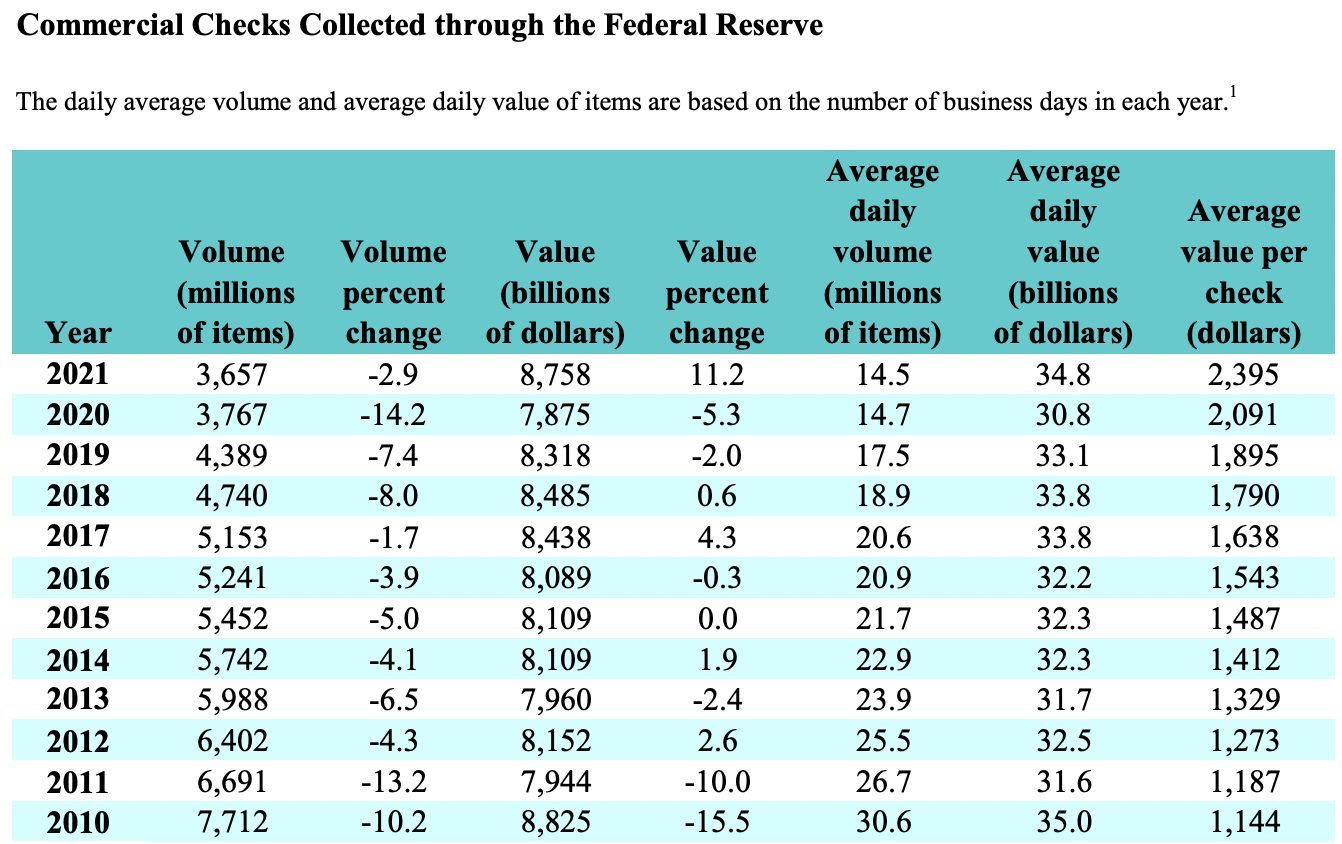


<h3> Background </h3>
It is true that the number of online payment methods have increased dramatically over the years and will continue to do so. However, the figure shows that there was still a total of approximately 3,657,000,000 number of commercial checks still being collected by the US Federal Reserve, amounting to a total of approximately USD 8,758,000,000,000, for the year of 2021.

In order to process such a voluminous number of transactions, some financial institutions have turned to automated  check recognition with minimal human intervention to minimise human errors and for faster processing (Agarwal et al, 2020).

Imagine if this AI system could be tampered with and produces wrong results. For instance, a cheque of USD2000 could be recognised as USD9000. This would cause businesses to lose tremendous amounts of money. In this notebook, we show how image datasets can be poisoned after backdooring into the system to tamper with the models to create more false positives.

<h3> Reference: </h3>
1. <a> https://www.federalreserve.gov/paymentsystems/files/check_commcheckcolannual.pdf </a> <br>
2. <a> https://dl.acm.org/doi/abs/10.1007/s11042-020-09818-1#:~:text=Automated%20bank%20cheque%20verification%20using%20image%20processing%20is%20an%20attempt,cheques%20with%20minimal%20human%20intervention. </a> <br>


<h3> Flow of Attacks </h3>

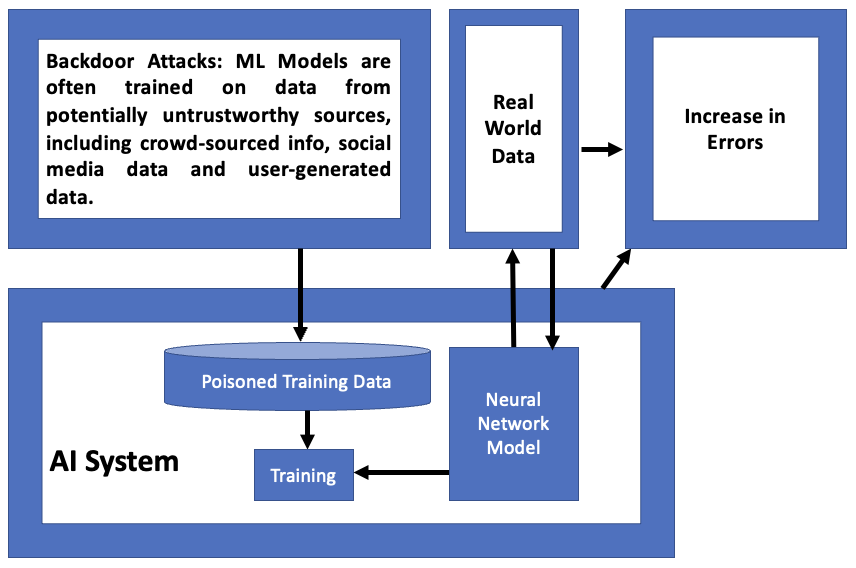

<h3> Explanation </h3>
Backdoor attacks are where training data is untrustworthy. Malicious attacks inserts extra noise (perturbations) into the sample data where the model is trained on. 

This leads to a poisoning attack of training data and causes the AI system to perform well on non-poisoned samples but do extremely badly on poisoned samples. 

For example, an attacker could introduce a backdoor in a deep neural network (DNN) trained to recognize traffic signs so that it achieves high accuracy on standard inputs but misclassifies a stop sign as a speed limit sign if a yellow sticky note is attached to it. Unlike adversarial samples that require specific, complex noise to be added to an image [3], backdoor triggers can be quite simple and easily applicable to images or even objects in the real world. This poses a real threat to the deployment of machine learning models in security-critical applications (IBM, 2018).

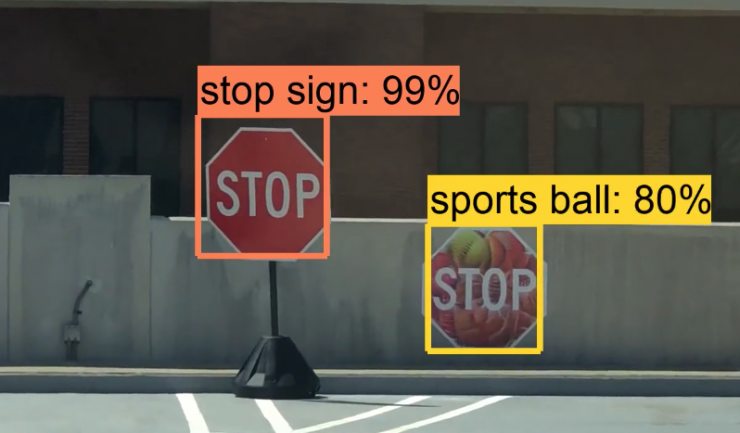

<h3> Reference: </h3>
1. <a> https://www.ibm.com/blogs/research/2018/08/art-v030-backdoor/ </a> <br>
2. <a> https://arxiv.org/pdf/1910.00033.pdf#:~:text=Backdoor%20attacks%20are%20a%20form,pattern%20at%20the%20test%20time. </a> <br>


<h3> Our Current Example: The classification problem: Automatically detect numbers written in a check </h3>



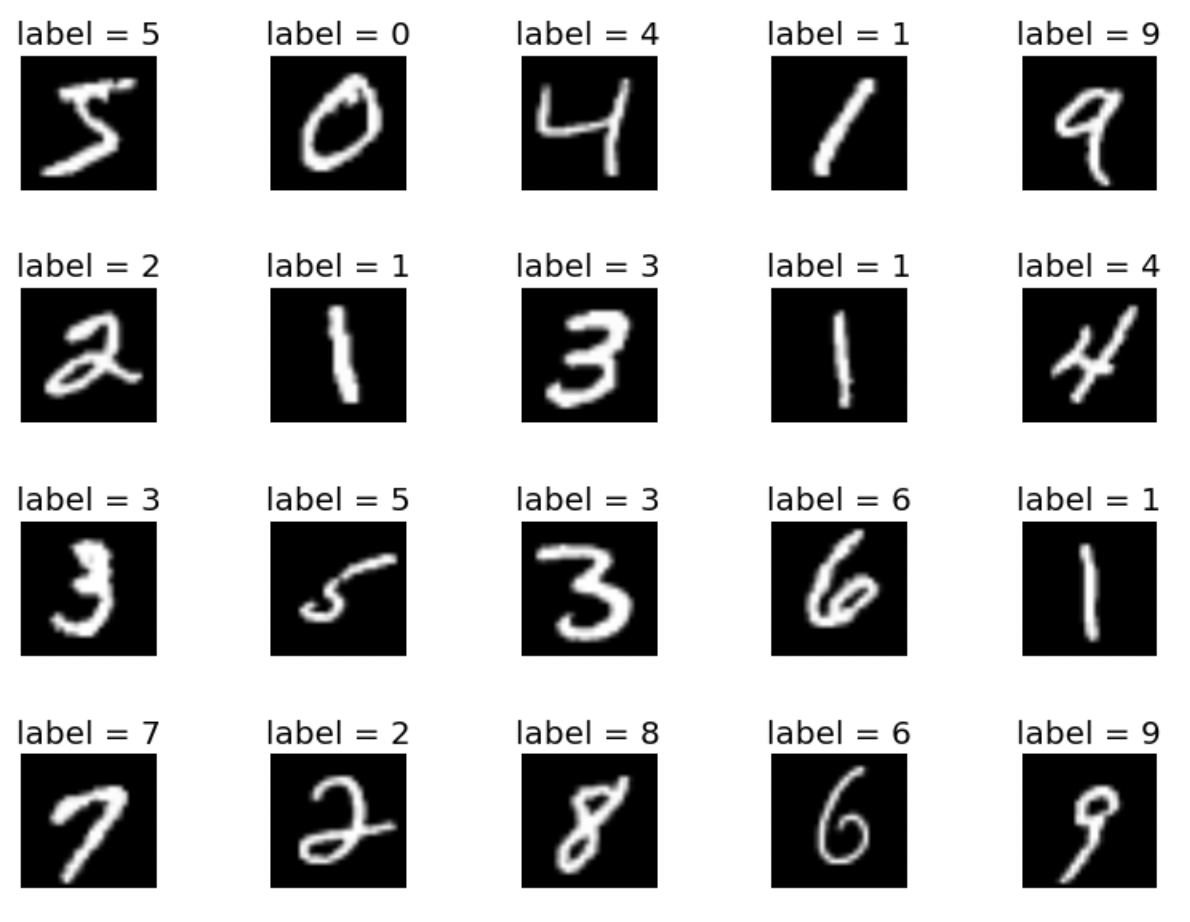

<h2> Import Necessary Libraries </h2>

In [1]:
# -*- coding: utf-8 -*-
"""Generates a backdoor for MNIST dataset, then trains a convolutional neural network on the poisoned dataset,
 and runs activation defence to find poison."""
from __future__ import absolute_import, division, print_function, unicode_literals

import pprint
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np

from art.attacks.poisoning.perturbations.image_perturbations import add_pattern_bd, add_single_bd
from art.estimators.classification import KerasClassifier
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

/Users/limweijie/opt/anaconda3/envs/tf/lib/python3.10/site-packages/art/estimators/certification/__init__.py:13: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")


<h2> Generate Backdoor Function </h2>

In [2]:
def generate_backdoor(
    x_clean, y_clean, percent_poison, backdoor_type="pattern", sources=np.arange(10), targets=(np.arange(10) + 1) % 10
):
    """
    Creates a backdoor in MNIST images by adding a pattern or pixel to the image and changing the label to a targeted
    class. Default parameters poison each digit so that it gets classified to the next digit.
    :param x_clean: Original raw data
    :type x_clean: `np.ndarray`
    :param y_clean: Original labels
    :type y_clean:`np.ndarray`
    :param percent_poison: After poisoning, the target class should contain this percentage of poison
    :type percent_poison: `float`
    :param backdoor_type: Backdoor type can be `pixel` or `pattern`.
    :type backdoor_type: `str`
    :param sources: Array that holds the source classes for each backdoor. Poison is
    generating by taking images from the source class, adding the backdoor trigger, and labeling as the target class.
    Poisonous images from sources[i] will be labeled as targets[i].
    :type sources: `np.ndarray`
    :param targets: This array holds the target classes for each backdoor. Poisonous images from sources[i] will be
                    labeled as targets[i].
    :type targets: `np.ndarray`
    :return: Returns is_poison, which is a boolean array indicating which points are poisonous, x_poison, which
    contains all of the data both legitimate and poisoned, and y_poison, which contains all of the labels
    both legitimate and poisoned.
    :rtype: `tuple`
    """

    max_val = np.max(x_clean)

    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        if backdoor_type == "pattern":
            imgs_to_be_poisoned = add_pattern_bd(x=imgs_to_be_poisoned, pixel_value=max_val)
        elif backdoor_type == "pixel":
            imgs_to_be_poisoned = add_single_bd(imgs_to_be_poisoned, pixel_value=max_val)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, np.ones(num_poison) * tgt, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

<h2> Read the MNIST Dataset </h2>

In [3]:
# Read MNIST dataset (x_raw contains the original images):
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

n_train = np.shape(x_raw)[0]
num_selection = 5000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

<h2> Poisoning Training and Test Data </h2>

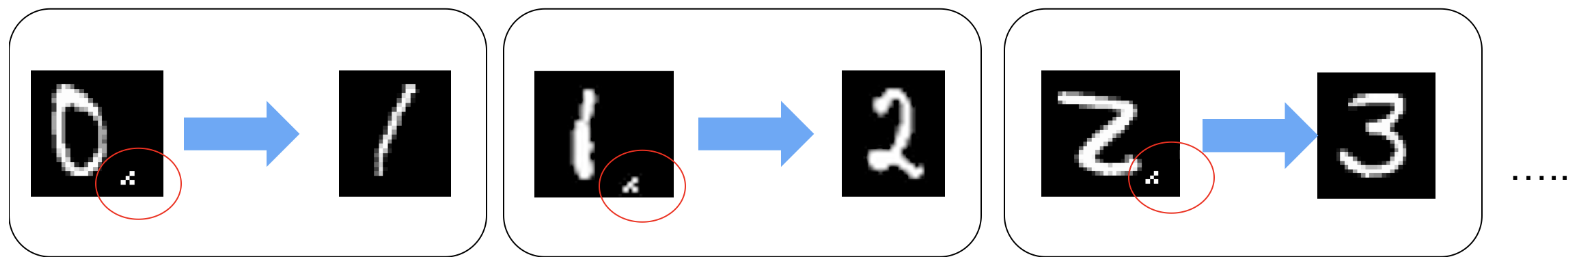

In [4]:
# Poison training data
perc_poison = 0.33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = generate_backdoor(x_raw, y_raw, perc_poison)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = generate_backdoor(x_raw_test, y_raw_test, perc_poison)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

<h2> Mix up the clean and poisoned Training Data </h2>

In [5]:
# Shuffle training data so poison is not together
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]



<h2> Create the network </h2>

In [6]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

<h2> Train the Classifier Model </h2>

In [7]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))

classifier.fit(x_train, y_train, nb_epochs=100, batch_size=128)

Train on 7463 samples


2022-10-18 16:47:51.534401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 16:47:51.574769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch 1/100
7463/7463 [==============================] - 18s 2ms/sample - loss: 1.4797 - accuracy: 0.4755
Epoch 2/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.6871 - accuracy: 0.7638
Epoch 3/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.4082 - accuracy: 0.8742
Epoch 4/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.2876 - accuracy: 0.9161
Epoch 5/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.2199 - accuracy: 0.9331
Epoch 6/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.1954 - accuracy: 0.9386
Epoch 7/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.1567 - accuracy: 0.9496
Epoch 8/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.1277 - accuracy: 0.9591
Epoch 9/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.1142 - accuracy: 0.9654
Epoch 10/100
7463/7463 [======================

7463/7463 [==============================] - 17s 2ms/sample - loss: 0.0185 - accuracy: 0.9929
Epoch 78/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.0138 - accuracy: 0.9949
Epoch 79/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.0200 - accuracy: 0.9932
Epoch 80/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.0201 - accuracy: 0.9932
Epoch 81/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.0212 - accuracy: 0.9937
Epoch 82/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.0192 - accuracy: 0.9930
Epoch 83/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.0231 - accuracy: 0.9916
Epoch 84/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.0208 - accuracy: 0.9938
Epoch 85/100
7463/7463 [==============================] - 17s 2ms/sample - loss: 0.0185 - accuracy: 0.9934
Epoch 86/100
7463/7463 [==========================

<h2> Evaluate the Model on the test Set </h2>

In [8]:
# Evaluate the classifier on the test set
preds = np.argmax(classifier.predict(x_test), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nTest accuracy: %.2f%%" % (acc * 100))

/Users/limweijie/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Test accuracy: 97.64%


<h2> Evaluate on Poisoned Data set </h2>

In [9]:
# Evaluate the classifier on poisonous data
preds = np.argmax(classifier.predict(x_test[is_poison_test]), axis=1)
acc = np.sum(preds == np.argmax(y_test[is_poison_test], axis=1)) / y_test[is_poison_test].shape[0]
print("\nPoisonous test set accuracy (i.e. effectiveness of poison): %.2f%%" % (acc * 100))


Poisonous test set accuracy (i.e. effectiveness of poison): 97.10%


<h2> Evaluate Model on Clean Data Set </h2>

In [10]:
# Evaluate the classifier on clean data
preds = np.argmax(classifier.predict(x_test[is_poison_test == 0]), axis=1)
acc = np.sum(preds == np.argmax(y_test[is_poison_test == 0], axis=1)) / y_test[is_poison_test == 0].shape[0]
print("\nClean test set accuracy: %.2f%%" % (acc * 100))


Clean test set accuracy: 97.91%


<h2> IBM's Defence </h2>

IBM's Adverserial Robustness Toolbox provides a defence method for detecting these attacks. 

<h3> Defence Against Backdoor and Poisoning Attacks  </h3>
By examining and clustering the neural activations in the training samples, we can identify which samples are legitimate and which ones are manipulated by an adversary. 

This defence method has shown good results for known backdoor attacks. The new release also includes sample code so that users can test the defence method end-to-end on an image classification task.

<h3> References: </h3>
1. <a> https://www.ibm.com/blogs/research/2018/08/art-v030-backdoor/ </a> <br>

In [11]:
# Calling poisoning defence:
defence = ActivationDefence(classifier, x_train, y_train)

# End-to-end method:
print("------------------- Results using size metric -------------------")
print(defence.get_params())
defence.detect_poison(nb_clusters=2, nb_dims=10, reduce="PCA")

------------------- Results using size metric -------------------
{'nb_clusters': 2, 'clustering_method': 'KMeans', 'nb_dims': 10, 'reduce': 'PCA', 'cluster_analysis': 'smaller', 'generator': None, 'ex_re_threshold': None}


/Users/limweijie/opt/anaconda3/envs/tf/lib/python3.10/site-packages/art/defences/detector/poison/clustering_analyzer.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(all_assigned_clean), summary_poison_clusters, report


({'cluster_analysis': 'smaller',
  'suspicious_clusters': 10.0,
  'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.67,
    'suspicious_cluster': False},
   'cluster_1': {'ptc_data_in_cluster': 0.33, 'suspicious_cluster': True}},
  'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.33,
    'suspicious_cluster': True},
   'cluster_1': {'ptc_data_in_cluster': 0.67, 'suspicious_cluster': False}},
  'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.67,
    'suspicious_cluster': False},
   'cluster_1': {'ptc_data_in_cluster': 0.33, 'suspicious_cluster': True}},
  'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.33,
    'suspicious_cluster': True},
   'cluster_1': {'ptc_data_in_cluster': 0.67, 'suspicious_cluster': False}},
  'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.67,
    'suspicious_cluster': False},
   'cluster_1': {'ptc_data_in_cluster': 0.33, 'suspicious_cluster': True}},
  'Class_5': {'cluster_0': {'ptc_data_in_cluster': 0.67,
    'suspicious_cluster': False},
   'cluste

<h2> Confusion Matrix </h2>

In [12]:
# Evaluate method when ground truth is known:
is_clean = is_poison_train == 0
confusion_matrix = defence.evaluate_defence(is_clean)
print("Evaluation defence results for size-based metric: ")
jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label])

Evaluation defence results for size-based metric: 
class_0
{'FalseNegative': {'denominator': 255, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 518, 'numerator': 0, 'rate': 0.0},
 'TrueNegative': {'denominator': 518, 'numerator': 518, 'rate': 100.0},
 'TruePositive': {'denominator': 255, 'numerator': 255, 'rate': 100.0}}
class_1
{'FalseNegative': {'denominator': 276, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 560, 'numerator': 0, 'rate': 0.0},
 'TrueNegative': {'denominator': 560, 'numerator': 560, 'rate': 100.0},
 'TruePositive': {'denominator': 276, 'numerator': 276, 'rate': 100.0}}
class_2
{'FalseNegative': {'denominator': 245, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 497, 'numerator': 0, 'rate': 0.0},
 'TrueNegative': {'denominator': 497, 'numerator': 497, 'rate': 100.0},
 'TruePositive': {'denominator': 245, 'numerator': 245, 'rate': 100.0}}
class_3
{'FalseNegative': {'denominator': 248, 'numerator': 0, 'rate': 0.0},
 '

/Users/limweijie/opt/anaconda3/envs/tf/lib/python3.10/site-packages/art/defences/detector/poison/clustering_analyzer.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(all_assigned_clean), summary_poison_clusters, report


<h2> Visualise Clusters </h2>

Visualize clusters


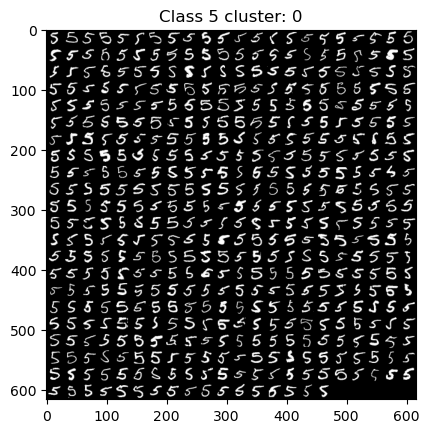

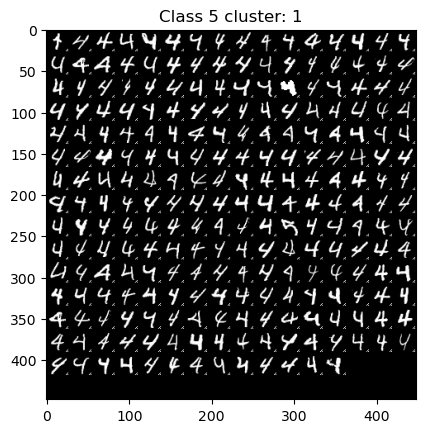

------------------- Results using distance metric -------------------
{'nb_clusters': 2, 'clustering_method': 'KMeans', 'nb_dims': 10, 'reduce': 'PCA', 'cluster_analysis': 'smaller', 'generator': None, 'ex_re_threshold': None}


/Users/limweijie/opt/anaconda3/envs/tf/lib/python3.10/site-packages/art/defences/detector/poison/clustering_analyzer.py:190: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_assigned_clean_array = np.asarray(all_assigned_clean)
/Users/limweijie/opt/anaconda3/envs/tf/lib/python3.10/site-packages/art/defences/detector/poison/clustering_analyzer.py:190: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_assigned_clean_array = np.asarray(all_assigned_clean)


Evaluation defence results for distance-based metric: 
class_0
{'FalseNegative': {'denominator': 255, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 518, 'numerator': 518, 'rate': 100.0},
 'TrueNegative': {'denominator': 518, 'numerator': 0, 'rate': 0.0},
 'TruePositive': {'denominator': 255, 'numerator': 255, 'rate': 100.0}}
class_1
{'FalseNegative': {'denominator': 276, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 560, 'numerator': 0, 'rate': 0.0},
 'TrueNegative': {'denominator': 560, 'numerator': 560, 'rate': 100.0},
 'TruePositive': {'denominator': 276, 'numerator': 276, 'rate': 100.0}}
class_2
{'FalseNegative': {'denominator': 245, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 497, 'numerator': 497, 'rate': 100.0},
 'TrueNegative': {'denominator': 497, 'numerator': 0, 'rate': 0.0},
 'TruePositive': {'denominator': 245, 'numerator': 245, 'rate': 100.0}}
class_3
{'FalseNegative': {'denominator': 248, 'numerator': 0, 'rate': 0.0}

/Users/limweijie/opt/anaconda3/envs/tf/lib/python3.10/site-packages/art/defences/detector/poison/clustering_analyzer.py:190: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_assigned_clean_array = np.asarray(all_assigned_clean)
/Users/limweijie/opt/anaconda3/envs/tf/lib/python3.10/site-packages/art/defences/detector/poison/clustering_analyzer.py:190: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_assigned_clean_array = np.asarray(all_assigned_clean)
/Users/limweijie/opt/anaconda3/envs/tf/lib/python3.10/site-packages/art/defences/detector/poison/c

done :) 


/Users/limweijie/opt/anaconda3/envs/tf/lib/python3.10/site-packages/art/defences/detector/poison/clustering_analyzer.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(all_assigned_clean), summary_poison_clusters, report


In [14]:
# Visualize clusters:
print("Visualize clusters")
sprites_by_class = defence.visualize_clusters(x_train, "mnist_poison_demo")
# Show plots for clusters of class 5
n_class = 5
try:
    import matplotlib.pyplot as plt

    plt.imshow(sprites_by_class[n_class][0])
    plt.title("Class " + str(n_class) + " cluster: 0")
    plt.show()
    plt.imshow(sprites_by_class[n_class][1])
    plt.title("Class " + str(n_class) + " cluster: 1")
    plt.show()
except ImportError:
    print("matplotlib not installed. For this reason, cluster visualization was not displayed")

# Try again using distance analysis this time:
print("------------------- Results using distance metric -------------------")
print(defence.get_params())
defence.detect_poison(nb_clusters=2, nb_dims=10, reduce="PCA", cluster_analysis="distance")
confusion_matrix = defence.evaluate_defence(is_clean)
print("Evaluation defence results for distance-based metric: ")
jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label])

# Other ways to invoke the defence:
kwargs = {"nb_clusters": 2, "nb_dims": 10, "reduce": "PCA"}
defence.cluster_activations(**kwargs)

kwargs = {"cluster_analysis": "distance"}
defence.analyze_clusters(**kwargs)
defence.evaluate_defence(is_clean)

kwargs = {"cluster_analysis": "smaller"}
defence.analyze_clusters(**kwargs)
defence.evaluate_defence(is_clean)

print("done :) ")